In [4]:
!pip install nltk rouge-score pandas matplotlib tqdm pythainlp -q
!pip install bert-score -q

In [7]:
import json
import numpy as np
import pandas as pd
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk
nltk.download('punkt', quiet=True)

# For handling Thai language
import pythainlp
from pythainlp.tokenize import word_tokenize

# For ROUGE score
from rouge_score import rouge_scorer

# Create a proper tokenizer class for ROUGE
class ThaiTokenizer:
    def tokenize(self, text):
        return word_tokenize(text, engine="newmm")

def preprocess_text(text, use_thai_tokenizer=True):
    """Clean and preprocess text."""
    # Remove markdown headings
    text = re.sub(r'#+ ', '', text)
    # Remove extra newlines and whitespace
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Tokenize if needed
    if use_thai_tokenizer:
        return word_tokenize(text, engine="newmm")
    return text.split()

def calculate_bleu(reference, candidate, already_tokenized=True):
    """Calculate BLEU scores between reference and candidate texts."""
    # Check if already tokenized
    if not already_tokenized:
        reference_tokens = preprocess_text(reference)
        candidate_tokens = preprocess_text(candidate)
    else:
        reference_tokens = reference
        candidate_tokens = candidate

    # BLEU requires a list of references
    references = [reference_tokens]

    # Use smoothing to avoid zero scores
    smoothie = SmoothingFunction().method1

    # Calculate BLEU-1 to BLEU-4
    bleu1 = sentence_bleu(references, candidate_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
    bleu2 = sentence_bleu(references, candidate_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    bleu3 = sentence_bleu(references, candidate_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie)
    bleu4 = sentence_bleu(references, candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie)

    return {
        'bleu1': bleu1,
        'bleu2': bleu2,
        'bleu3': bleu3,
        'bleu4': bleu4
    }

def calculate_rouge(reference, candidate, use_thai_tokenizer=True):
    """Calculate ROUGE scores between reference and candidate texts."""
    # For ROUGE, we need string inputs
    if not isinstance(reference, str):
        reference = ' '.join(reference)
    if not isinstance(candidate, str):
        candidate = ' '.join(candidate)

    # Create appropriate tokenizer
    if use_thai_tokenizer:
        tokenizer = ThaiTokenizer()
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'],
                                         tokenizer=tokenizer,
                                         use_stemmer=False)
    else:
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'],
                                         use_stemmer=False)

    scores = scorer.score(reference, candidate)

    return {
        'rouge1_precision': scores['rouge1'].precision,
        'rouge1_recall': scores['rouge1'].recall,
        'rouge1_f1': scores['rouge1'].fmeasure,
        'rouge2_precision': scores['rouge2'].precision,
        'rouge2_recall': scores['rouge2'].recall,
        'rouge2_f1': scores['rouge2'].fmeasure,
        'rougeL_precision': scores['rougeL'].precision,
        'rougeL_recall': scores['rougeL'].recall,
        'rougeL_f1': scores['rougeL'].fmeasure
    }

def calculate_bert_scores(references, candidates, model_name='xlm-roberta-base'):
    """Calculate BERT-Score between references and candidates."""
    try:
        from bert_score import score

        # Ensure inputs are strings for bert-score
        if not isinstance(references[0], str):
            references = [' '.join(ref) if isinstance(ref, list) else ref for ref in references]
        if not isinstance(candidates[0], str):
            candidates = [' '.join(cand) if isinstance(cand, list) else cand for cand in candidates]

        # Calculate BERT scores
        P, R, F1 = score(candidates, references, lang="th",
                         model_type=model_name, verbose=True)

        # Convert to numpy arrays
        P_np = P.cpu().numpy()
        R_np = R.cpu().numpy()
        F1_np = F1.cpu().numpy()

        return P_np, R_np, F1_np

    except Exception as e:
        print(f"\nError calculating BERT-Score: {e}")
        print("Returning placeholder values (zeros).")
        return np.zeros(len(references)), np.zeros(len(references)), np.zeros(len(references))

def evaluate_metrics(file_path, use_thai_tokenizer=True, bert_model=None):
    """Evaluate text generation with multiple metrics."""
    print(f"Loading data from {file_path}...")

    # Load the data
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    test_cases = data['test_cases']
    print(f"Found {len(test_cases)} test cases")

    # Lists to store results
    results = []

    # Store original texts for BERT-Score
    golden_originals = []
    inference_originals = []

    # Process each test case
    for tc in tqdm(test_cases, desc="Calculating BLEU and ROUGE"):
        # Extract data
        question_id = tc['id']
        question = tc['question']
        golden_answer = tc['golden_answer']
        inference_result = tc['inference_result']

        # Store original texts for BERT-Score
        golden_originals.append(golden_answer)
        inference_originals.append(inference_result)

        # Preprocess texts
        golden_proc = preprocess_text(golden_answer, use_thai_tokenizer)
        inference_proc = preprocess_text(inference_result, use_thai_tokenizer)

        # Calculate BLEU scores
        bleu_scores = calculate_bleu(golden_proc, inference_proc, already_tokenized=True)

        # Calculate ROUGE scores
        rouge_scores = calculate_rouge(golden_answer, inference_result, use_thai_tokenizer)

        # Store basic results
        result = {
            'id': question_id,
            'question': question,
            **bleu_scores,
            **rouge_scores
        }
        results.append(result)

    # Calculate BERT-Score if specified
    if bert_model:
        print(f"\nCalculating BERT-Score using {bert_model}...")
        P, R, F1 = calculate_bert_scores(
            golden_originals,
            inference_originals,
            model_name=bert_model
        )

        # Add BERT scores to results
        for i, result in enumerate(results):
            result['bert_precision'] = P[i]
            result['bert_recall'] = R[i]
            result['bert_f1'] = F1[i]

    # Create a DataFrame
    df = pd.DataFrame(results)

    # Calculate and print average scores
    print("\nAverage scores:")
    print(f"BLEU-1: {df['bleu1'].mean():.4f}")
    print(f"BLEU-2: {df['bleu2'].mean():.4f}")
    print(f"BLEU-3: {df['bleu3'].mean():.4f}")
    print(f"BLEU-4: {df['bleu4'].mean():.4f}")
    print(f"ROUGE-1 F1: {df['rouge1_f1'].mean():.4f}")
    print(f"ROUGE-2 F1: {df['rouge2_f1'].mean():.4f}")
    print(f"ROUGE-L F1: {df['rougeL_f1'].mean():.4f}")

    if bert_model and 'bert_f1' in df.columns:
        print(f"BERT-Score Precision: {df['bert_precision'].mean():.4f}")
        print(f"BERT-Score Recall: {df['bert_recall'].mean():.4f}")
        print(f"BERT-Score F1: {df['bert_f1'].mean():.4f}")

    # Print individual scores for key metrics
    print("\nIndividual scores (ID, BLEU-4, ROUGE-L F1):")
    for i, row in df.iterrows():
        bert_score = f", {row['bert_f1']:.4f}" if bert_model and 'bert_f1' in df.columns else ""
        print(f"{row['id']}: {row['bleu4']:.4f}, {row['rougeL_f1']:.4f}{bert_score}")

    # Save results to CSV
    output_file = 'evaluation_results.csv'
    df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")

    # Create visualization
    create_visualization(df, bert_model is not None and 'bert_f1' in df.columns, 'evaluation_metrics.png')

    return df

def create_visualization(df, has_bert, output_file):
    """Create visualization of metrics."""
    print(f"\nCreating visualization ({output_file})...")

    # Determine number of plots
    n_plots = 3 if has_bert else 2

    # Create figure
    fig, axs = plt.subplots(n_plots, 1, figsize=(10, 4 * n_plots))

    # Get test case IDs as strings
    ids = df['id'].astype(str)

    # Plot BLEU scores
    axs[0].bar(ids, df['bleu4'], color='skyblue')
    axs[0].set_title('BLEU-4 Scores')
    axs[0].set_xlabel('Test Case ID')
    axs[0].set_ylabel('Score')
    axs[0].set_ylim(0, 1)
    axs[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot ROUGE-L F1 scores
    axs[1].bar(ids, df['rougeL_f1'], color='lightgreen')
    axs[1].set_title('ROUGE-L F1 Scores')
    axs[1].set_xlabel('Test Case ID')
    axs[1].set_ylabel('Score')
    axs[1].set_ylim(0, 1)
    axs[1].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot BERT-Score F1 if available
    if has_bert:
        axs[2].bar(ids, df['bert_f1'], color='salmon')
        axs[2].set_title('BERT-Score F1')
        axs[2].set_xlabel('Test Case ID')
        axs[2].set_ylabel('Score')
        axs[2].set_ylim(0, 1)
        axs[2].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(output_file)

    # Display the figure in Colab
    plt.show()
    print(f"Visualization saved to {output_file}")



Loading data from tax-test-results.json...
Found 10 test cases


Calculating BLEU and ROUGE:   0%|          | 0/10 [00:00<?, ?it/s]


Calculating BERT-Score using xlm-roberta-base...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 26.64 seconds, 0.38 sentences/sec

Average scores:
BLEU-1: 0.3936
BLEU-2: 0.3459
BLEU-3: 0.3095
BLEU-4: 0.2725
ROUGE-1 F1: 0.5134
ROUGE-2 F1: 0.3722
ROUGE-L F1: 0.4219
BERT-Score Precision: 0.8618
BERT-Score Recall: 0.9142
BERT-Score F1: 0.8870

Individual scores (ID, BLEU-4, ROUGE-L F1):
1: 0.1784, 0.2961, 0.9017
2: 0.2396, 0.4723, 0.8854
3: 0.1097, 0.2442, 0.8588
4: 0.3564, 0.5663, 0.9157
5: 0.3873, 0.5572, 0.9086
6: 0.4964, 0.6530, 0.9119
7: 0.2618, 0.4416, 0.8827
8: 0.2948, 0.3897, 0.9016
9: 0.1097, 0.1721, 0.8188
10: 0.2903, 0.4262, 0.8844

Results saved to evaluation_results.csv

Creating visualization (evaluation_metrics.png)...


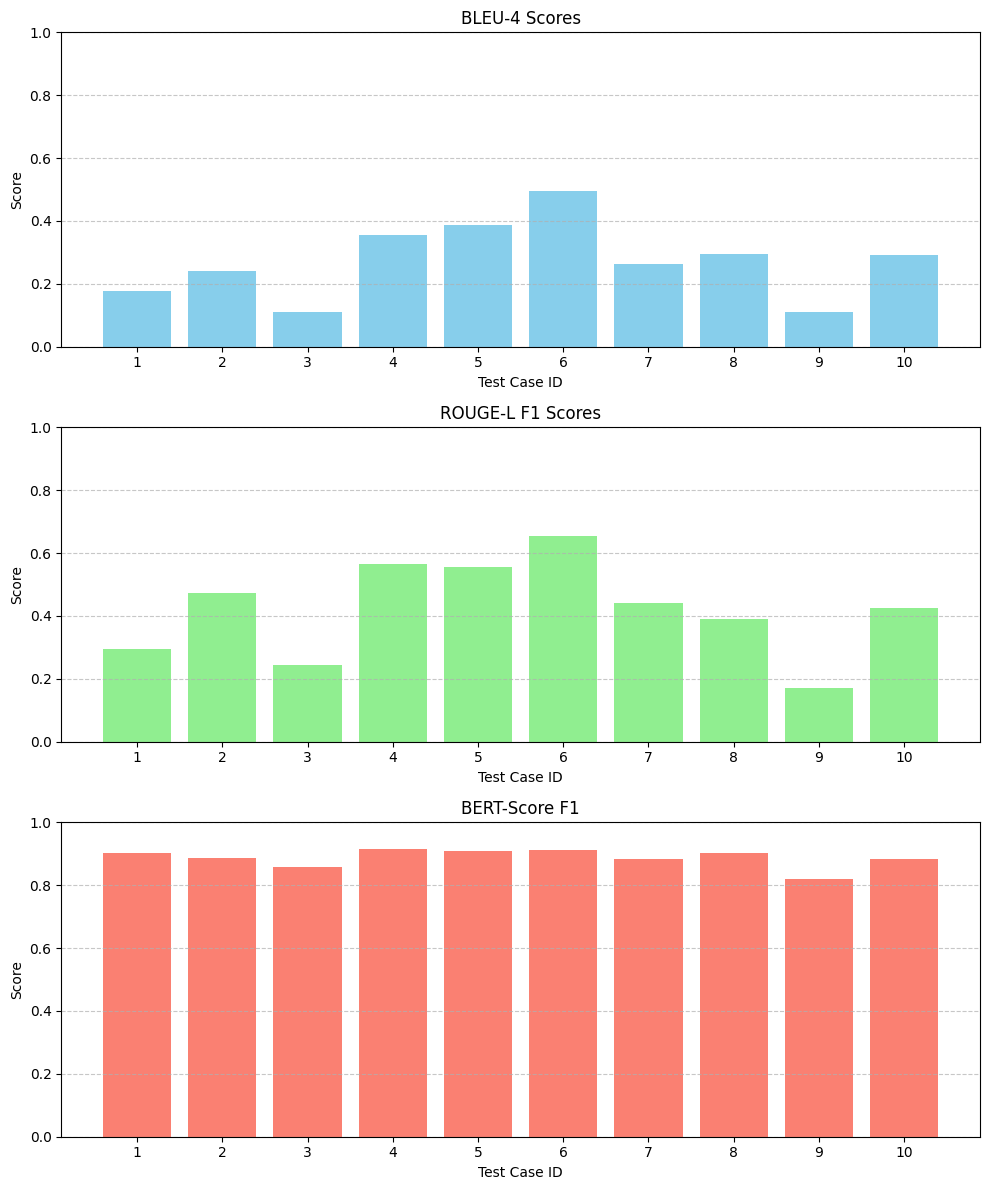

Visualization saved to evaluation_metrics.png


In [8]:
df = evaluate_metrics('tax-test-results.json', use_thai_tokenizer=True, bert_model='xlm-roberta-base')

In [9]:
df = pd.read_csv('evaluation_results.csv')
df

,id,question,bleu1,bleu2,bleu3,bleu4,rouge1_precision,rouge1_recall,rouge1_f1,rouge2_precision,rouge2_recall,rouge2_f1,rougeL_precision,rougeL_recall,rougeL_f1,bert_precision,bert_recall,bert_f1
0,1,ใครบ้างที่มีหน้าที่เสียภาษีเงินได้บุคคลธรรมดา?,0.208020,0.200612,0.191604,0.178435,0.202439,1.000000,0.336714,0.173594,0.865854,0.289206,0.178049,0.879518,0.296146,0.843523,0.968436,0.901674
1,2,เงินได้ประเภทใดบ้างที่ต้องเสียภาษีเงินได้บุคคล...,0.342697,0.310554,0.278798,0.239641,0.334552,0.943299,0.493927,0.260073,0.735751,0.384303,0.319927,0.902062,0.472335,0.851792,0.921751,0.885391
2,3,เมื่อมีเงินได้แล้ว ผู้มีหน้าที่เสียภาษีจะต้องด...,0.202020,0.163011,0.136210,0.109718,0.192308,0.821918,0.311688,0.120385,0.517241,0.195312,0.150641,0.643836,0.244156,0.821412,0.899663,0.858758
3,4,ผู้ที่มีเงินได้เกิดขึ้นระหว่างปีภาษีทุกกรณีต้อ...,0.451039,0.417743,0.389220,0.356358,0.433048,0.987013,0.601980,0.345714,0.790850,0.481113,0.407407,0.928571,0.566337,0.893531,0.939066,0.915733
4,5,วิธีการคำนวณภาษีเงินได้บุคคลธรรมดาสิ้นปีต้องทำ...,0.521452,0.469731,0.429232,0.387289,0.497638,0.897727,0.640324,0.389590,0.703704,0.501523,0.433071,0.781250,0.557244,0.892760,0.925041,0.908614
5,6,เงินได้พึงประเมินแต่ละประเภทสามารถหักค่าใช้จ่า...,0.617021,0.573500,0.537629,0.496443,0.581162,0.884146,0.701330,0.475904,0.724771,0.574545,0.541082,0.823171,0.652963,0.899036,0.925108,0.911886
6,7,แบบแสดงรายการภาษีเงินได้บุคคลธรรมดาประเภทใดบ้า...,0.466793,0.363632,0.310753,0.261811,0.445652,0.833898,0.580874,0.246824,0.462585,0.321893,0.338768,0.633898,0.441558,0.857068,0.910007,0.882745
7,8,มีวิธีการชำระภาษีเงินได้บุคคลธรรมดาวิธีใดบ้าง?,0.432000,0.377949,0.335178,0.294768,0.410646,0.850394,0.553846,0.285714,0.592885,0.385604,0.288973,0.598425,0.389744,0.878740,0.925685,0.901602
8,9,หากไม่ชำระภาษีภายในกำหนดเวลาหรือชำระไม่ถูกต้อง...,0.227924,0.180768,0.143977,0.109721,0.216553,0.682143,0.328744,0.130533,0.412186,0.198276,0.113379,0.357143,0.172117,0.811488,0.826346,0.818850
9,10,ผู้มีเงินได้สามารถหักลดหย่อนภาษีอะไรได้บ้าง?,0.467249,0.401778,0.342470,0.290339,0.454031,0.820972,0.584699,0.303116,0.548718,0.390511,0.330976,0.598465,0.426230,0.868705,0.900650,0.884389


In [11]:
import pandas as pd; df = pd.read_csv('evaluation_results.csv'); print(f"BERTScoreF1 Avg: {df['bert_f1'].mean():.4f}, Avg ROUGE-L F1: {df['rougeL_f1'].mean():.4f}, Avg BLEU-4: {df['bleu4'].mean():.4f}")

BERTScoreF1 Avg: 0.8870, Avg ROUGE-L F1: 0.4219, Avg BLEU-4: 0.2725
